# Collaborative Filtering for Implicit Feedback Datasets

### Cost function for squared error with regularization

Across all x (users) and y (items), find the values of u and i that minimize the summation below:

$\underset{x,y}min\underset{u,i}\sum 
c_{ui} (p_{ui} - x_u^Ty_i)^2 + \lambda
(\underset u \sum \parallel x_u \parallel ^2
+\underset u \sum \parallel y_i \parallel ^2)$

##### Where:

$x_u$ is user vector,
$y_i$ is item vector.

$p_{ui} = 1$ if interaction, 
$p_{ui} = 0$ if no interaction.

$c_{ui} = 1 + \alpha * r_{ui}$, where
$r_{ui}$ = # of interactions for a user-item pair, and $\alpha$ determines our confidence levels.

$\lambda$ is regularization term.

#### Explanation of cost function

We take the squared error of our prediction and 
multiply by the confidence, and regularize our $x$ and $y$ vectors with $\lambda$ to penalize overfitting. (larger values or smaller values?)

$\alpha$ allows us to influence our confidence levels. Clearly, our confidence increases when a producer samples the same artist multiple times, but by how much? $\alpha$ determines how important multiple samples are.

We add 1 so that non-interactions are not lost during the cost calculation.

### ALS Algorithm

However, we can't use the cost function above because of the size of the dataset. (m * n terms)

Therefore we modify the cost function to Alternating Least Squares, which works by holding either user vectors or item vectors constant and calculating the global minimum, then alternating to the other vector.

#### Compute user factors

$x_u = (Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

##### Where:

$Y$ is $n * f$ matrix of item-factors. 

$C^u$ is a $n*n$ diagonal matrix for user $u$ where $C^u_{ii} = c_{ui}$. Each $C^u$ is our confidence matrix for $n$ items for $u$ user.

$p(u)$ is vector of preferences for user $u$.


#### Recompute item factors

$y_i = (X^TC^iX + \lambda I)^-1 X^TC^ip(i)$

##### Where:
$X$ = $m * f$ matrix  of user_factors. 

$C^i$ is $m * m$ diagonal matrix for each item $i$ where $C_{uu}^i = c_{ui}$

$p(i)$ is vector of preferences for item $i$.

### Explaining recommendations

If $\hat{p}_{ui}$, the predicted preference of user $u$ at item $i$, is equal to $y_i^Tx_u$, we can substite our user_factor equation for $x_u$. This gives us:

$\hat{p}_{ui} =  y_i^T(Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

Denote $f*f$ matrix $(Y^T C^u Y + \lambda I)^{-1}$ as $W^u$

$W^u$ is considered the weight for user $u$


## Import libraries

In [2]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd

import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import os, sys
os.environ["OPENBLAS_NUM_THREADS"]="1"

import random

np.set_printoptions(threshold=sys.maxsize)

from src.test_ranking import *

## Read in the data from the Mongo collection

In [3]:
df = clean_up_mongo_coll(db.main_redo)

## Turn df to utility matrix

In [4]:
user_art = turn_df_to_util_mat_at_limits(
    df, 'new_song_producer', 'new_song_artist')

### Perform Test/Train Split

We can't do the traditional time split for recommendation systems, because the algorithm requires the entire
dataframe to train on. Instead, we create a test set by taking some percentage of the actual interactions, and 
replacing them with zeros- in other words, acting as if the producer has not sampled those artists.

We train the model on this `train` dataset with these specific values hidden. 

In [5]:
user_inds, item_inds = get_indices_of_test_set_values(user_art, 5)

train, test = make_train_set_and_test_set(user_inds, item_inds, user_art)

## Fit model on training data 

The implicit library has a fast implementation of the alternating least squares algorithm, which I use below. 

The model's fit method expects the sparse utility matrix to be as item/user- however, ours is in user-item.

Therefore, the model's item_vecs is our user_vecs, and vice versa.

## Explore Model

The item factors attribute refers to our user_vectors, since we trained it backwards

To explore the recommendations and other attributes, will probably be simplest to retrain the model with a item_user matrix.

In [15]:
user_vecs = train_model.item_factors.shape

train_model.

(16865, 100)

## Test model

We need a metric to evaluate how our model is performing on the test data.
### Ranking Algorithm

$\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$

#### where:
$r^t_{ui}$ is the # of interactions for observations in the test set, and 

$rank_{ui}$ are the percentile ranking of each item for each user.

#### Explanation

We can see that $\sum_{u,i} r^t_{ui}$ is in both the numerator and the denominator. If $rank_{ui}$ was not in the numerator, $\overline{rank}$ would simply equal 1. $rank_{ui}$ is the percentile ranking of each item for each user, such that the item most highly recommended has a $rank_{ui}$ of 0.00\% and the item least recommended has a $rank_{ui}$ of 100.00\%.

Therefore, if the algorithm is correct, the low percentages will cancel out the high $r^t_{ui}$, making the $\overline{rank}$ go towards 0.

#### Methodology

1. Get denominator by summing the # of user-item interactions at the test set indices. This is $\sum_{u,i} r^t_{ui}$, for  $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$   

2. Get the $rank_{ui}$ of our model for all $u, i$ in $r^t_{ui}$. This is calculated by getting the predictions of the ALS model, ranking them, taking their percentage, and then selecting only the ones at the selected indices.

3. Get rtui 

4. Multiply $rank_{ui}$ by $r^t_{ui}$ to get numerator. Divide by $rank_{ui}$ to get $\overline{rank}$

5. Use popularity as a baseline for the model. Instead of using the model to rank different songs for artists, the $rank_{ui}$ of popularity for all $u, i$ in $r^t_{ui}$. This is popularity rank score.

1. Get denominator by summing the # of user-item interactions at the test set indices. This is $\sum_{u,i} r^t_{ui}$, for  $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$ 

2. Get the $rank_{ui}$ of our model for all $u, i$ in $r^t_{ui}$. This is calculated by getting the predictions of the ALS model, ranking them, taking their percentage, and then selecting only the ones at the selected indices.

3. Get $r^t_{ui}$

4. Multiply $rank_{ui}$ by $r^t_{ui}$ to get numerator. Divide by $rank_{ui}$ to get $\overline{rank}$

## Compare to baseline: Just recommend what's popular.

## Putting it all together

In Yuwan He's paper, they say that more factors is better without fail.
So I originally try to run the model with 400 factors.

In [31]:
rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 400)

print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))

100%|██████████| 15.0/15 [00:18<00:00,  1.38s/it]


Model rank score: 0.49518219533845137 
Popularity rank score: 0.13483235058642565


## Evaluation
My model does not do as well as popularity unfortunately.

# Testing at different # of factors

Plot the results

100%|██████████| 15.0/15 [00:00<00:00, 47.97it/s]
100%|██████████| 15.0/15 [00:00<00:00, 25.04it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.74it/s]
100%|██████████| 15.0/15 [00:00<00:00, 25.31it/s]
100%|██████████| 15.0/15 [00:03<00:00,  3.95it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.58it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.39it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.45it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.64it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.31it/s]
100%|██████████| 15.0/15 [00:05<00:00,  2.72it/s]
100%|██████████| 15.0/15 [00:06<00:00,  2.35it/s]
100%|██████████| 15.0/15 [00:08<00:00,  1.87it/s]
100%|██████████| 15.0/15 [00:09<00:00,  1.50it/s]
100%|██████████| 15.0/15 [00:10<00:00,  1.27it/s]
100%|██████████| 15.0/15 [00:11<00:00,  1.34it/s]
100%|██████████| 15.0/15 [00:13<00:00,  1.06s/it]
100%|██████████| 15.0/15 [00:16<00:00,  1.05s/it]
100%|██████████| 15.0/15 [00:19<00:00,  1.35s/it]


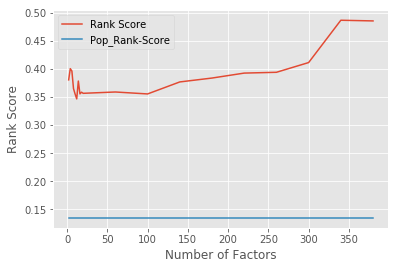

In [32]:
# Look up factors between 2 and 400

a = list(range(2, 20, 2))
b = list(range(20,400, 40))
factors = a + b
vals = []

for factor in factors:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, factor)

    vals.append([factor, rank_score, pop_rank_score])

fig, ax = plt.subplots()

ax.plot(factors, [val[1] for val in vals], label = "Rank Score")
ax.plot(factors, [val[2] for val in vals], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
ax.annotate(xy = (12, .325), s = "12 factors")
_ = ax.set(ylabel = "Rank Score", xlabel = "Number of Factors")

# Testing at different values of lambda

In [7]:
# Look up factors between 2 and 400

regularizations = np.logspace(-2, 4, 7)
vals = []

for regularization in regularizations:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 12, regularization)

    vals.append([regularization, rank_score, pop_rank_score])


100%|██████████| 15.0/15 [00:03<00:00,  3.71it/s]
100%|██████████| 15.0/15 [00:03<00:00,  4.32it/s]
100%|██████████| 15.0/15 [00:03<00:00,  5.39it/s]
100%|██████████| 15.0/15 [00:03<00:00,  5.47it/s]
100%|██████████| 15.0/15 [00:02<00:00,  6.74it/s]
100%|██████████| 15.0/15 [00:01<00:00,  9.77it/s]
100%|██████████| 15.0/15 [00:02<00:00,  7.12it/s]


In [11]:
vals

[[0.01, 0.3708672471203205, 0.11861958376317443],
 [0.1, 0.3357370245195887, 0.11861958376317443],
 [1.0, 0.36797867471481516, 0.11861958376317443],
 [10.0, 0.3723759729993528, 0.11861958376317443],
 [100.0, 0.36491884697469207, 0.11861958376317443],
 [1000.0, 0.47531235678604045, 0.11861958376317443],
 [10000.0, 0.4081003753143095, 0.11861958376317443]]

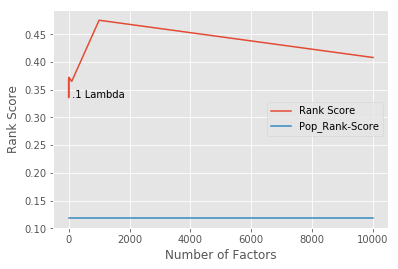

In [16]:
fig, ax = plt.subplots()

ax.plot(regularizations, [val[1] for val in vals], label = "Rank Score")
ax.plot(regularizations, [val[2] for val in vals], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
ax.annotate(xy = (100, .335), s = ".1 Lambda")
_ = ax.set(ylabel = "Rank Score", xlabel = "Number of Factors")

In [ ]:
# Look up factors between 2 and 400

regularizations = np.arange(.01, .91, .1)
vals = []

for regularization in regularizations:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 12, regularization)

    vals.append([regularization, rank_score, pop_rank_score])


100%|██████████| 15.0/15 [00:03<00:00,  3.84it/s]
100%|██████████| 15.0/15 [00:03<00:00,  4.70it/s]
100%|██████████| 15.0/15 [00:04<00:00,  4.01it/s]


In [ ]:
fig, ax = plt.subplots()

ax.plot(regularizations, [val[1] for val in vals], label = "Rank Score")
ax.plot(regularizations, [val[2] for val in vals], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
#ax.annotate(xy = (12, .325), s = "12 factors")
_ = ax.set(ylabel = "Rank Score", xlabel = "Number of Factors")

# Testing different values of iterations

In [ ]:
# Look up factors between 2 and 400

iterations = [range(10, 210, 40)]
vals = []

for iteration in iterations:
    
    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 12, regularization)

    vals.append([iteration, rank_score, pop_rank_score])
    
fig, ax = plt.subplots()

ax.plot(iterations, [val[1] for val in vals], label = "Rank Score")
ax.plot(iterations, [val[2] for val in vals], label = "Pop_Rank-Score")
ax.legend(loc = 'best')
ax.annotate(xy = (12, .325), s = "12 factors")
_ = ax.set(ylabel = "Rank Score", xlabel = "Number of Factors")

## Try different num_prods, num_artists


In [13]:
vals = []

for num_prod in range(1, 30, 3):
    for num_artist in range(1, 30, 3):
        
        user_art = turn_df_to_util_mat_at_limits(
            df, 'new_song_producer', 'new_song_artist', num_prod, num_artist)
        
        user_inds, item_inds = get_indices_of_test_set_values(user_art, 5)

        train, test = make_train_set_and_test_set(user_inds, item_inds, user_art)

        rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
            train, test, user_inds, item_inds, 20)        

        print(
        "Model rank score: {} \n\
        Popularity rank score: {}".format(rank_score, pop_rank_score))
        
        vals.append([num_prod, num_artist, rank_score, pop_rank_score])
        
print(vals)

pd.DataFrame(vals).to_csv('diff_limits_prods_artists.csv')

100%|██████████| 15.0/15 [00:02<00:00,  6.69it/s]


Model rank score: 0.30290723010546944 
        Popularity rank score: 0.15307103752392792


100%|██████████| 15.0/15 [00:01<00:00, 10.22it/s]


Model rank score: 0.3320251296407805 
        Popularity rank score: 0.20282479963160782


100%|██████████| 15.0/15 [00:01<00:00, 13.68it/s]


Model rank score: 0.319311630767723 
        Popularity rank score: 0.20400645419200727


100%|██████████| 15.0/15 [00:01<00:00, 13.20it/s]


Model rank score: 0.37533285730629184 
        Popularity rank score: 0.2028721174831232


100%|██████████| 15.0/15 [00:00<00:00, 18.05it/s]


Model rank score: 0.3640995747756451 
        Popularity rank score: 0.24789171059645357


100%|██████████| 15.0/15 [00:00<00:00, 16.12it/s]


Model rank score: 0.408486264065631 
        Popularity rank score: 0.32513380547039583


100%|██████████| 15.0/15 [00:00<00:00, 16.94it/s]


Model rank score: 0.3478849728562546 
        Popularity rank score: 0.2918186925267274


100%|██████████| 15.0/15 [00:00<00:00, 23.64it/s]


Model rank score: 0.3873007643267232 
        Popularity rank score: 0.30912697685886376


100%|██████████| 15.0/15 [00:00<00:00, 27.36it/s]


Model rank score: 0.3434236197036272 
        Popularity rank score: 0.2360076626299432


100%|██████████| 15.0/15 [00:00<00:00, 26.75it/s]


Model rank score: 0.37555307778076824 
        Popularity rank score: 0.31619631665961784


100%|██████████| 15.0/15 [00:01<00:00, 12.28it/s]


Model rank score: 0.3003742576689009 
        Popularity rank score: 0.14879345057977608


100%|██████████| 15.0/15 [00:00<00:00, 18.45it/s]


Model rank score: 0.3303072722465191 
        Popularity rank score: 0.19400733573427334


100%|██████████| 15.0/15 [00:00<00:00, 20.76it/s]


Model rank score: 0.34989025754747716 
        Popularity rank score: 0.26375442947816136


100%|██████████| 15.0/15 [00:00<00:00, 22.09it/s]


Model rank score: 0.307655044739278 
        Popularity rank score: 0.2336675408824437


100%|██████████| 15.0/15 [00:00<00:00, 22.49it/s]


Model rank score: 0.3264704477672606 
        Popularity rank score: 0.27166714933873926


100%|██████████| 15.0/15 [00:00<00:00, 29.25it/s]


Model rank score: 0.35762270498909626 
        Popularity rank score: 0.2784633760190748


100%|██████████| 15.0/15 [00:00<00:00, 30.70it/s]


Model rank score: 0.3730685024417871 
        Popularity rank score: 0.29252127790130744


100%|██████████| 15.0/15 [00:00<00:00, 31.80it/s]


Model rank score: 0.3759572580344001 
        Popularity rank score: 0.2654857855149652


100%|██████████| 15.0/15 [00:00<00:00, 37.17it/s]


Model rank score: 0.2835612628510051 
        Popularity rank score: 0.30565652012684774


100%|██████████| 15.0/15 [00:00<00:00, 37.70it/s]


Model rank score: 0.370178697019939 
        Popularity rank score: 0.23086459092397887


100%|██████████| 15.0/15 [00:01<00:00, 12.69it/s]


Model rank score: 0.337486165988239 
        Popularity rank score: 0.186327388340994


100%|██████████| 15.0/15 [00:00<00:00, 19.51it/s]


Model rank score: 0.3221453661689119 
        Popularity rank score: 0.19512330992522786


100%|██████████| 15.0/15 [00:00<00:00, 20.96it/s]


Model rank score: 0.28077079872709904 
        Popularity rank score: 0.21580465959634676


100%|██████████| 15.0/15 [00:00<00:00, 26.25it/s]


Model rank score: 0.3747711075782658 
        Popularity rank score: 0.2163950596441205


100%|██████████| 15.0/15 [00:00<00:00, 34.96it/s]


Model rank score: 0.342194708626511 
        Popularity rank score: 0.25689692388979096


100%|██████████| 15.0/15 [00:00<00:00, 35.39it/s]


Model rank score: 0.35650006294509967 
        Popularity rank score: 0.216549417317889


100%|██████████| 15.0/15 [00:00<00:00, 37.33it/s]


Model rank score: 0.3440336718563564 
        Popularity rank score: 0.258530155562567


100%|██████████| 15.0/15 [00:00<00:00, 35.64it/s]


Model rank score: 0.41158520937670523 
        Popularity rank score: 0.3039943245973732


100%|██████████| 15.0/15 [00:00<00:00, 44.46it/s]


Model rank score: 0.387614225334924 
        Popularity rank score: 0.3639699234637331


100%|██████████| 15.0/15 [00:00<00:00, 45.43it/s]


Model rank score: 0.36426109852542 
        Popularity rank score: 0.2702593273523419


100%|██████████| 15.0/15 [00:00<00:00, 20.11it/s]


Model rank score: 0.3051036379867983 
        Popularity rank score: 0.15770138831270786


100%|██████████| 15.0/15 [00:00<00:00, 26.01it/s]


Model rank score: 0.30325100123869114 
        Popularity rank score: 0.16751675848519568


100%|██████████| 15.0/15 [00:00<00:00, 33.21it/s]


Model rank score: 0.33194194849100894 
        Popularity rank score: 0.21728446194107803


100%|██████████| 15.0/15 [00:00<00:00, 38.20it/s]


Model rank score: 0.34242816114110897 
        Popularity rank score: 0.2311604515616888


100%|██████████| 15.0/15 [00:00<00:00, 41.57it/s]


Model rank score: 0.40339558871900627 
        Popularity rank score: 0.24583370291116458


100%|██████████| 15.0/15 [00:00<00:00, 46.60it/s]


Model rank score: 0.39902764615988795 
        Popularity rank score: 0.2801121277703787


100%|██████████| 15.0/15 [00:00<00:00, 48.39it/s]


Model rank score: 0.34556549624566807 
        Popularity rank score: 0.27027128658066996


100%|██████████| 15.0/15 [00:00<00:00, 52.55it/s]


Model rank score: 0.37567050441010286 
        Popularity rank score: 0.30797707627056453


100%|██████████| 15.0/15 [00:00<00:00, 54.60it/s]


Model rank score: 0.37325280227841745 
        Popularity rank score: 0.32594506931966827


100%|██████████| 15.0/15 [00:00<00:00, 58.03it/s]


Model rank score: 0.38727167980347105 
        Popularity rank score: 0.3425533273639115


100%|██████████| 15.0/15 [00:00<00:00, 22.63it/s]


Model rank score: 0.3585846936614757 
        Popularity rank score: 0.15990875984086278


100%|██████████| 15.0/15 [00:00<00:00, 33.03it/s]


Model rank score: 0.314079208507361 
        Popularity rank score: 0.17518735144912023


100%|██████████| 15.0/15 [00:00<00:00, 38.89it/s]


Model rank score: 0.3432837289713412 
        Popularity rank score: 0.1778167431345169


100%|██████████| 15.0/15 [00:00<00:00, 40.32it/s]


Model rank score: 0.33557767905681635 
        Popularity rank score: 0.22870074895876147


100%|██████████| 15.0/15 [00:00<00:00, 45.61it/s]


Model rank score: 0.4358829462593556 
        Popularity rank score: 0.23493186855545917


100%|██████████| 15.0/15 [00:00<00:00, 52.91it/s]


Model rank score: 0.3447028402043434 
        Popularity rank score: 0.20755341588356074


100%|██████████| 15.0/15 [00:00<00:00, 51.18it/s]


Model rank score: 0.297716565241462 
        Popularity rank score: 0.2805611538183799


100%|██████████| 15.0/15 [00:00<00:00, 57.20it/s]


Model rank score: 0.32727405652790575 
        Popularity rank score: 0.2428516422726187


100%|██████████| 15.0/15 [00:00<00:00, 54.45it/s]


Model rank score: 0.28546594290392907 
        Popularity rank score: 0.24332461281200557


100%|██████████| 15.0/15 [00:00<00:00, 65.97it/s]


Model rank score: 0.34151829787234045 
        Popularity rank score: 0.3545304964539007


100%|██████████| 15.0/15 [00:00<00:00, 24.94it/s]


Model rank score: 0.35908384838358837 
        Popularity rank score: 0.1388206340875798


100%|██████████| 15.0/15 [00:00<00:00, 32.13it/s]


Model rank score: 0.3245473166292915 
        Popularity rank score: 0.15854640487849617


100%|██████████| 15.0/15 [00:00<00:00, 42.30it/s]


Model rank score: 0.3011491024435131 
        Popularity rank score: 0.21697417299751717


100%|██████████| 15.0/15 [00:00<00:00, 44.08it/s]


Model rank score: 0.3102543004904917 
        Popularity rank score: 0.22608712191658076


100%|██████████| 15.0/15 [00:00<00:00, 45.69it/s]


Model rank score: 0.3283102865961678 
        Popularity rank score: 0.23708327852827396


100%|██████████| 15.0/15 [00:00<00:00, 54.30it/s]


Model rank score: 0.3151776154089504 
        Popularity rank score: 0.28328349718930235


100%|██████████| 15.0/15 [00:00<00:00, 58.37it/s]


Model rank score: 0.34197071314545036 
        Popularity rank score: 0.2706766665662661


100%|██████████| 15.0/15 [00:00<00:00, 51.92it/s]


Model rank score: 0.39359263187439614 
        Popularity rank score: 0.3168164848894309


100%|██████████| 15.0/15 [00:00<00:00, 62.66it/s]


Model rank score: 0.3164524476841721 
        Popularity rank score: 0.33840025385170663


100%|██████████| 15.0/15 [00:00<00:00, 63.97it/s]


Model rank score: 0.36426897975121325 
        Popularity rank score: 0.33930360083527156


100%|██████████| 15.0/15 [00:00<00:00, 27.87it/s]


Model rank score: 0.31439801783807064 
        Popularity rank score: 0.12031106410479006


100%|██████████| 15.0/15 [00:00<00:00, 36.26it/s]


Model rank score: 0.3530502987331873 
        Popularity rank score: 0.185180792519882


100%|██████████| 15.0/15 [00:00<00:00, 44.04it/s]


Model rank score: 0.36571747540848665 
        Popularity rank score: 0.230984020660987


100%|██████████| 15.0/15 [00:00<00:00, 49.53it/s]


Model rank score: 0.377116958524001 
        Popularity rank score: 0.29478482309441717


100%|██████████| 15.0/15 [00:00<00:00, 58.22it/s]


Model rank score: 0.2766493421360678 
        Popularity rank score: 0.2692148442464498


100%|██████████| 15.0/15 [00:00<00:00, 63.43it/s]


Model rank score: 0.37379500169817736 
        Popularity rank score: 0.26493087003283144


100%|██████████| 15.0/15 [00:00<00:00, 64.75it/s]


Model rank score: 0.3414914104248236 
        Popularity rank score: 0.3158121965401742


100%|██████████| 15.0/15 [00:00<00:00, 69.45it/s]


Model rank score: 0.3115733681681072 
        Popularity rank score: 0.24849653674973024


100%|██████████| 15.0/15 [00:00<00:00, 76.18it/s]


Model rank score: 0.39062927651640605 
        Popularity rank score: 0.2550933915156126


100%|██████████| 15.0/15 [00:00<00:00, 76.46it/s]


Model rank score: 0.3095922762618503 
        Popularity rank score: 0.31305494240071924


100%|██████████| 15.0/15 [00:00<00:00, 28.53it/s]


Model rank score: 0.3179588158729099 
        Popularity rank score: 0.12875212762406968


100%|██████████| 15.0/15 [00:00<00:00, 35.47it/s]


Model rank score: 0.3164819190970146 
        Popularity rank score: 0.18351396837146916


100%|██████████| 15.0/15 [00:00<00:00, 44.12it/s]


Model rank score: 0.36369896983603417 
        Popularity rank score: 0.2414621078126743


100%|██████████| 15.0/15 [00:00<00:00, 54.18it/s]


Model rank score: 0.3634299871755484 
        Popularity rank score: 0.19317226612270613


100%|██████████| 15.0/15 [00:00<00:00, 63.77it/s]


Model rank score: 0.3100823725335147 
        Popularity rank score: 0.2514090038627518


100%|██████████| 15.0/15 [00:00<00:00, 62.04it/s]


Model rank score: 0.30642022370886096 
        Popularity rank score: 0.19169840582786152


100%|██████████| 15.0/15 [00:00<00:00, 74.42it/s]


Model rank score: 0.3213834505270221 
        Popularity rank score: 0.2970916801800542


100%|██████████| 15.0/15 [00:00<00:00, 65.92it/s]


Model rank score: 0.34440188837363983 
        Popularity rank score: 0.22474432403205435


100%|██████████| 15.0/15 [00:00<00:00, 77.68it/s]


Model rank score: 0.34711887530107166 
        Popularity rank score: 0.29077193605063817


100%|██████████| 15.0/15 [00:00<00:00, 64.84it/s]


Model rank score: 0.2944332766886337 
        Popularity rank score: 0.2896046614443017


100%|██████████| 15.0/15 [00:00<00:00, 33.59it/s]


Model rank score: 0.32707501518425214 
        Popularity rank score: 0.1468581666384555


100%|██████████| 15.0/15 [00:00<00:00, 44.64it/s]


Model rank score: 0.3536843850263875 
        Popularity rank score: 0.13881108415255894


100%|██████████| 15.0/15 [00:00<00:00, 57.87it/s]


Model rank score: 0.31292761052480833 
        Popularity rank score: 0.21892562901307272


100%|██████████| 15.0/15 [00:00<00:00, 67.03it/s]


Model rank score: 0.39791246696232585 
        Popularity rank score: 0.24367852503183773


100%|██████████| 15.0/15 [00:00<00:00, 65.85it/s]


Model rank score: 0.3305921581415429 
        Popularity rank score: 0.228603370857044


100%|██████████| 15.0/15 [00:00<00:00, 76.95it/s]


Model rank score: 0.2728962480283057 
        Popularity rank score: 0.22948979387665946


100%|██████████| 15.0/15 [00:00<00:00, 80.79it/s]


Model rank score: 0.3280761917157659 
        Popularity rank score: 0.2098379247511174


100%|██████████| 15.0/15 [00:00<00:00, 80.89it/s]


Model rank score: 0.27101383691009806 
        Popularity rank score: 0.31195906732157197


100%|██████████| 15.0/15 [00:00<00:00, 79.07it/s]


Model rank score: 0.34900505708923685 
        Popularity rank score: 0.2836468346632666


100%|██████████| 15.0/15 [00:00<00:00, 98.39it/s]


Model rank score: 0.2904563533081357 
        Popularity rank score: 0.22103731672211976


100%|██████████| 15.0/15 [00:00<00:00, 32.76it/s]


Model rank score: 0.3080132893773833 
        Popularity rank score: 0.12288588704395625


100%|██████████| 15.0/15 [00:00<00:00, 50.88it/s]


Model rank score: 0.34672746316258324 
        Popularity rank score: 0.14233099177134273


100%|██████████| 15.0/15 [00:00<00:00, 55.59it/s]


Model rank score: 0.34151084471831256 
        Popularity rank score: 0.22343988195808898


100%|██████████| 15.0/15 [00:00<00:00, 71.39it/s]


Model rank score: 0.35217964569286947 
        Popularity rank score: 0.2546237522113148


100%|██████████| 15.0/15 [00:00<00:00, 73.75it/s]


Model rank score: 0.34839592331012353 
        Popularity rank score: 0.22507273058295515


100%|██████████| 15.0/15 [00:00<00:00, 82.14it/s]


Model rank score: 0.3578203148871842 
        Popularity rank score: 0.258459175632428


100%|██████████| 15.0/15 [00:00<00:00, 80.87it/s]


Model rank score: 0.35072910425784704 
        Popularity rank score: 0.20483615463509247


100%|██████████| 15.0/15 [00:00<00:00, 87.44it/s]


Model rank score: 0.36382713427105945 
        Popularity rank score: 0.26892169357122625


100%|██████████| 15.0/15 [00:00<00:00, 91.22it/s]


Model rank score: 0.3754424614470655 
        Popularity rank score: 0.3710420374941774


100%|██████████| 15.0/15 [00:00<00:00, 103.98it/s]

Model rank score: 0.3148167137048864 
        Popularity rank score: 0.29607873774809
[[1, 1, 0.30290723010546944, 0.15307103752392792], [1, 4, 0.3320251296407805, 0.20282479963160782], [1, 7, 0.319311630767723, 0.20400645419200727], [1, 10, 0.37533285730629184, 0.2028721174831232], [1, 13, 0.3640995747756451, 0.24789171059645357], [1, 16, 0.408486264065631, 0.32513380547039583], [1, 19, 0.3478849728562546, 0.2918186925267274], [1, 22, 0.3873007643267232, 0.30912697685886376], [1, 25, 0.3434236197036272, 0.2360076626299432], [1, 28, 0.37555307778076824, 0.31619631665961784], [4, 1, 0.3003742576689009, 0.14879345057977608], [4, 4, 0.3303072722465191, 0.19400733573427334], [4, 7, 0.34989025754747716, 0.26375442947816136], [4, 10, 0.307655044739278, 0.2336675408824437], [4, 13, 0.3264704477672606, 0.27166714933873926], [4, 16, 0.35762270498909626, 0.2784633760190748], [4, 19, 0.3730685024417871, 0.29252127790130744], [4, 22, 0.3759572580344001, 0.2654857855149652], [4, 25, 0.2835612628510

## Split df by element sampled

Should we put interpolations in there? Not now.

In [45]:
elements = ["Direct Sample of Vocals / Lyrics", 'Direct Sample of Drums',
           'Direct Sample of Bass', 'Direct Sample of Multiple Elements', 
           'Direct Sample of Hook / Riff']
rank_scores = []

pop_scores = []

for element in elements:
    
    #filter df by element
    filtered_df = df[df.elements_sampled == element]
    
    #turn to utility
    user_art = turn_df_to_util_mat_at_limits(
        filtered_df, 'new_song_producer', 'new_song_artist')
    
    #make train and test sets
    user_inds, item_inds = get_indices_of_test_set_values(user_art, 5)
    train, test = make_train_set_and_test_set(user_inds, item_inds, user_art)
    
    rank_score, pop_score = get_rank_and_pop_score_from_train_test_model(train, test, user_inds, item_inds, 12)
    rank_scores.append(rank_score)
    pop_scores.append(pop_score)


100%|██████████| 15.0/15 [00:01<00:00,  9.64it/s]
100%|██████████| 15.0/15 [00:01<00:00, 13.65it/s]
100%|██████████| 15.0/15 [00:00<00:00, 120.84it/s]
100%|██████████| 15.0/15 [00:01<00:00,  8.53it/s]
100%|██████████| 15.0/15 [00:00<00:00, 19.63it/s]


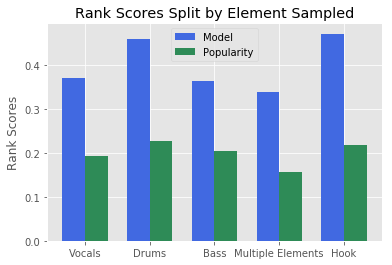

In [52]:
ax.bar(height = rank_scores, x = labels)
ax.bar(height = pop_scores, x = labels)
labels = ['Vocals', 'Drums', 'Bass', 'Multiple Elements', 'Hook']

N = 5

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, rank_scores, width, color='royalblue')
rects2 = ax.bar(ind+width, pop_scores, width, color='seagreen')

# add some
ax.set_ylabel('Rank Scores')
ax.set_title('Rank Scores Split by Element Sampled')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( labels )

_ = ax.legend( (rects1[0], rects2[0]), ('Model', 'Popularity') )

## Go through None Listed on producers

#### How many have all None Listed?
33 percent have none Listed for producers!

If they have None Listed for contributor (about 40), that probably means it failed. Because contributor is always listed.

Certain artists have more none listed than others.

Nearly 1/2 of the cells with missing producers are where the artist occurs less than 5 times in the df.

From the pie chart, nearly 3/4 of the missing producers are from artists who appear only 3 or less times in the dataset.



In [177]:
for col in df.columns:
    print("{} has {} with None Listed".format(col, len(df[df[col] == "None Listed" ])))

URL has 0 with None Listed
_id has 0 with None Listed
contributor_points has 48 with None Listed
elements_sampled has 44 with None Listed
name_of_contributor has 48 with None Listed
new_song_album has 18662 with None Listed
new_song_artist has 41 with None Listed
new_song_name has 41 with None Listed
new_song_producer has 64868 with None Listed
new_song_year has 42 with None Listed
presence_of_"and throughout"_in_description has 14987 with None Listed
sampled_artist has 1216 with None Listed
sampled_song_album has 20203 with None Listed
sampled_song_name has 1216 with None Listed
sampled_song_producer has 7 with None Listed
sampled_song_year has 2917 with None Listed
time_in_sampled_song_where_sample_appears has 14993 with None Listed


In [216]:
#Remove rows without artist, there's about 30
df = df[df.new_song_artist != "None Listed"]

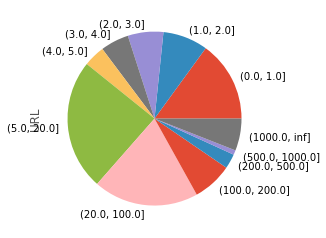

In [207]:
# Get the number of cells that are missing producer information
# for each new_song_artist and sort by artist with most missing.

df_none_listed_counts_per_artist = df[df.new_song_producer == "None Listed" ].\
    groupby("new_song_artist").\
    count()['URL'].sort_values(ascending = False)

# bin the none_listed_counts_per_artist, and take the mean and count
# of each bin

mean_per_bin = df_none_listed_counts_per_artist.groupby(
    pd.cut(df_none_listed_counts_per_artist, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    mean()

counts_per_bin = df_none_listed_counts_per_artist.value_counts().groupby(
    pd.cut(df_none_listed_counts_per_artist.value_counts().
    index, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    sum()

# #Mulitply together to the number of missing values 

num_cells_missing_prod_by_num_artist = mean_per_bin * counts_per_bin

# This has the correct sum, showing that this methodology was successful.

_ = num_cells_missing_prod_by_num_artist.plot(kind='pie')


In [217]:
#Replace none_listed in new_song_producer with NA

df.new_song_producer = df.new_song_producer.replace("None Listed", np.nan)

#Count number of NA in new_song_producer per new_song_artist. 
#Had to create a new dataframe in the process.
#Then join the 2 dataframes, and drop the extra columns formed by the join.
df2 = df['new_song_producer'].isnull()\
    .groupby(df['new_song_artist'])\
    .sum().astype(int).reset_index(name='num_producer_missing_per_artist')


df = df.join(df2.set_index('new_song_artist'), on ='new_song_artist', lsuffix='l')

#This line wasn't necessary the second time- not sure why
#df.drop(columns = ['num_producer_missing_per_artistl', '2'], inplace = True)

# Replace "None Listed" in new_song_producer with new_song_artist

## Try model on prods > n samples

66.78 % of the producers have more than 1 sample

In [346]:
#prepare dataframe from mongo

import re

df=pd.DataFrame(list(db.main_redo.find()))
df = df.drop_duplicates(['URL', 'new_song_producer'])
df = df[(df.new_song_producer != 'None Listed') & (df.sampled_artist != 'None Listed') ]
df.sampled_artist = df.sampled_artist.apply(lambda x: re.sub('\(.*\)', '', x))
df['new_song_producer'] = df.new_song_producer.apply(lambda x: re.sub('\(.*\)', '', x))
df2 = df.groupby('new_song_producer').filter(lambda x: len(x) > 2)

#turn into utility matrix
prod_artist_no_twos = pd.crosstab(df2.new_song_producer, df2.sampled_artist)


In [294]:
criteria2 = prod_artist.sum(axis = 0) > 4
low_prods_arts_removed = low_prods_removed.iloc[criteria2.values,]


IndexError: indices are out-of-bounds

In [354]:
prod_artist.loc['A Kid Called Roots'].sum()

11

# Try model on low_prods_removed

The model is predicting many zeros for my model.

I have gone through many different numbers of users/ artists, and all are giving numbers very close to random. 

I am going to try to run it against new_song_artist.

In [347]:
# Create test and train set
user_inds, item_inds = get_indices_of_test_set_values(prod_artist_no_twos, 5)
train, test = make_train_set_and_test_set(user_inds, item_inds, prod_artist_no_twos)

#1
denominator = get_denominator_for_rank_algorithm(user_inds, item_inds, test)

#3
rui = get_rui(test, user_inds, item_inds)

rank_score = get_rank_score_from_train_test_model(train, test, denominator, user_inds, item_inds, rui, 100)
pop_rank_score = get_pop_rank_score(test, item_inds, denominator)
print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))

100%|██████████| 15.0/15 [00:03<00:00,  4.89it/s]


Model rank score: 0.689588746240225 
Popularity rank score: 0.09809481152135491


# Split the data into 2016 after and before.


In [4]:
# What percentage of the data is 2018, 2017, etc?

np.cumsum(df.groupby('new_song_year').count()['URL'].apply(
    lambda x: (x / len(df)) * 100 ).sort_index(
    ascending = False))

# If we take the data past 2016-2019 as our test set, we get about 5%.

new_song_year
2019      0.127584
2018      1.752243
2017      3.614425
2016      5.619121
2015      8.069004
2014     10.856848
2013     14.537780
2012     18.091127
2011     21.231863
2010     24.333238
2009     26.670467
2008     29.158353
2007     31.654383
2006     34.037759
2005     36.783528
2004     39.245626
2003     41.907244
2002     44.100601
2001     46.638707
2000     49.208030
1999     52.375911
1998     55.539721
1997     58.646525
1996     62.246020
1995     65.739647
1994     70.241731
1993     74.872755
1992     80.081979
1991     84.847374
1990     88.833693
           ...    
1982     98.813741
1981     98.892463
1980     98.946754
1979     99.013261
1978     99.082482
1977     99.134058
1976     99.201922
1975     99.280644
1974     99.363438
1973     99.455732
1972     99.523596
1971     99.611819
1970     99.686469
1969     99.771978
1968     99.857486
1967     99.892775
1966     99.929422
1965     99.940280
1964     99.944352
1963     99.951138
1962     99.96335

In [280]:
test = df[df.new_song_year > 2014]
train = df[df.new_song_year < 2015]
print(test.shape)
print(train.shape)

(5945, 18)
(67732, 18)


In [297]:
# Songs and users have to be in both, right?

#get intersection of sampled_artist and song_producer from train and test set
def get_intersection_of_train_and_test_set(train, test, column):
    
    '''
    Takes train and test set and a column, and returns both filtered
    to have values they both share
    '''
    test_column = set(test[column])
    train_column = set(train[column])
    both_columns = test_column.intersection(train_column)
    print([len(test_column), len(train_column), len(both_columns)])
    
    test = test[test[column].isin(list(both_columns))]

    train = train[train[column].isin(list(both_columns))]
    
    return train, test

train, test = get_intersection_of_train_and_test_set(
    train, test, "sampled_artist")
train, test = get_intersection_of_train_and_test_set(
    train, test, "new_song_producer")

#I needed to run this 3 times to work

#I have 1163 artists, and 544 producers shared. 

[1163, 1164, 1163]
[544, 544, 544]
